# Case Study: Contrail Segmentation 

This notebook presents a set of exercises in the form of a case study on segmenting contrails from satellite image (also referred to as remote sensing data). In it you will be introduced to a data science scenario you will have to tackle, challenge the issue of data scarcity, talk about the ethics of the usage of your model, and how to verify your model works on a technical level.

*Prerequisties*:
- Basic machine learning knowledge 

*The goal by the end of this notebook is for students to:*
- Gain an exposure to a new application of artificial intelligence - extracing semantics from satellite images.
- Understand when they can consider the specifics of their data and task.
- Think about the implications of their machine learning beyound the technical - what will be my machine learning be used for? 
- Understand how to evaluate machine learning tasks based on the goal they are solving - how more complicated tasks need more complicated metrics.
- Become more informed as engineers in their place in the whole machine learning pipeline.

*The notebook is loosely based on the paper "Few-Shot Contrail Segmentation in Remote Sensing Imagery With Loss Function in Hough Space" by Junzi et al. It focuses on creating an automatic segmentation procedure for contrails when using few data samples by taking advantage of what we know about the problem.*



##  What is a contrail?

Contrails are line-shaped clouds produced by aircraft engine exhaust due to changes in air pressure, typically at aircraft cruising altitudes several kilometres/miles above the Earth's surface. (Definition - https://en.wikipedia.org/wiki/Contrail)

<p align="center">
  <img src="images/what-is-a-contrail.png" width="800"/>
</p>

[Image Source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fsites.research.google%2Fgr%2Fcontrails%2F&psig=AOvVaw128OqAWqIAmXihrXxVq9OS&ust=1763826829380000&source=images&cd=vfe&opi=89978449&ved=0CBEQjRxqFwoTCJjx8JHNg5EDFQAAAAAdAAAAABAE)

## Why does it matter?

The Sun emits solar radiation towards the Earth that the ground traditionally reflects back. However, the formation of the ice crystals in contrails creates a dense enough "shield" to reflect a part of them back. This impacts the amount of radiation trapped around the Earth and thus contributes to the temperature. They also have a potential cooling effect on sun rays getting reflected back towards the Sun, though this effect is currently estimated to be smaller.


## Problem Definition

The contrails reflect light and cool during the day, but trap heat during the night. This becomes an issue when contrails stick around for hours in specific regions – ISSRs – 80% of contrail warming  

## The Challenge

Contrails are already being measured by aircraft sensors and estimation models – as the ones responsible if something goes wrong. In the future, however, with issues like global warming, governments may want to do contrail reporting themselves. While there are already ways this being  done via sensors and other models, they are provided by the airlines. The government needs an independent version of these reports.

## Can we solve this with AI?

Yes, using satellite images and neural networks, we can make a model to segment the contrails from arbitrary images. Good news: using satellite 
images and neural networks, we can make a model to segment the contrails from arbitrary images 

###  What is Contrail Segmentation?

Contrail segmentation is a type of semantic segmentation, where the goal is to identify which parts of a satellite image contain contrails.

### Segmentation 

In normal image classification, you assign a single label to an entire image.
In segmentation, you label every pixel so the model can understand what objects appear and where they are.

### Contrail Segmentation

For contrail segmentation, there are only two pixel types:

- pixels that are part of a contrail
- pixels that are background

The model takes a satellite image and produces another image (a mask) showing where contrails are located.


<div style="display: flex; justify-content: space-around;">

   <img src="https://drive.google.com/thumbnail?id=1mJFmtqykU0petsHhJA6aXmH914tZaJCf" width="600"/>
   <img src="https://drive.google.com/thumbnail?id=1AGKlj_TgX67lI3t46-_PNkAFpdgU7gmZ" width="600">

</div>

[Image Source](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/data)


Below are listed some example images of contrail images taken from different satellites and bands: 


<div style="display: flex; justify-content: space-around;">
  <img src="https://drive.google.com/thumbnail?id=1tSknPvQ0TjfCUvSOrKhCsOybfr3bvU3h" width="350"/>
  <img src="https://drive.google.com/thumbnail?id=1CPoUeO49pJM_OaKdJfiMf9i51G_ScZ7z" width="350"/>
  <img src="https://drive.google.com/thumbnail?id=1eCHrhY-TAtQRHixCzNpVmhIyYNzE0RgB" width="350"/>
</div>



## The Scenario 
You are a data scientist at VeryCoolCompany Ltd. And the government has asked you to try to make this for them.  In this notebook you will tackle four challenges in regards to this: 

- **Data issues**: data is expensive, hard to get, label, etc. It costs money for your company. Sometimes even your datasets are samey. Different types of contrails 
- **Scientific Uncertainty**: Uncertainty in CO2 forcing, up to 70% of the actual impact on contrails
- **Model Quality and Uncertainty**
- **Policy Issues**: How should the government employ this tool you provide them?  Even if a policy is decided, how can it be enforced – globally, locally?  

## Project Setup

### IF LOCAL: Create an Anaconda Environment and Download Requirements
If you haven't already setup the codebase following the instructions of the README, you can do so here. Otherwise, you can skip running this.

In [ ]:
%conda create -y -n contrail-project python=3.12
%conda activate contrail-project
%conda install -y pip
%pip install -r requirements.txt

### IF ON COLAB: Download Repository 
### TOKEN: P5LF1pnyzLIZwLKQkR1pLm86MQp1OjN1Mgk.01.0z1rradpw 

In [1]:
from getpass import getpass
import os

token = getpass('Paste your GitLab token: ')
repo_url = "https://oauth2:" + token + "@gitlab.ewi.tudelft.nl/tjviering/contrails.git"
!git clone --branch data-augmentation --single-branch {repo_url}
!ls contrails  # Should show repository contents
os.chdir("contrails")
%pip install -r requirements.txt
os.chdir("data_util/AudioMNIST")
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git
os.chdir("../../")

Cloning into 'contrails'...
remote: HTTP Basic: Access denied. If a password was provided for Git authentication, the password was incorrect or you're required to use a token instead of a password. If a token was provided, it was either incorrect, expired, or improperly scoped. See https://gitlab.ewi.tudelft.nl/help/topics/git/troubleshooting_git.md#error-on-git-fetch-http-basic-access-denied
fatal: Authentication failed for 'https://gitlab.ewi.tudelft.nl/tjviering/contrails.git/'
ls: cannot access 'contrails': No such file or directory


FileNotFoundError: [Errno 2] No such file or directory: 'contrails'

### Get Imports

In [35]:
import os
import random
import numpy as np
import torch
import os
from sklearn.model_selection import train_test_split
from data_util.AudioMNIST.load_data import load_audio_data, load_audio_data_noisy
from visualization.show_audio import visualize_waveform_and_play_audio
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from data_util.AudioMNIST.split_data import get_balanced_indices_by_targets
from visualization.show_metrics import plot_accuracy_vs_subset_size
from torch import nn, optim
from tqdm import tqdm
from data_util.MNIST.raw.mnist_loading import load_mnist_data
from models.simpleCNN import SimpleCNN
from visualization.show_images import visualize_pytorch_dataset_images
import albumentations as A
from visualization.interactive_menu import retrieve_mnist_menu, AlbumentationsTransform
import sys
import cv2
sys.path.append("contrail-seg")
from train import train_contrail_network
seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Which Dataset to Choose? 

You are a data scientist. All of your issues start at the dataset you will use for the task at hand. Wherever you go, you first need to consider your domain. In this case, the domain is satellite images and flight trajectories. You need to consider which satellite to collect images from. 

<iframe src="https://drive.google.com/file/d/1J7-wbA8b5QWF_o-rdsUfArvNTpirGLac/preview" width="1000" height="600" allow="autoplay"></iframe>

[Image Source 1](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/data)
[Image Source 2](https://console.cloud.google.com/storage/browser/landsat_contrails_dataset)


We present you with two options: LandSAT and GEOS. In the following section, you have to answer the following overarching question, and then a series of questions: 

#### Does it matter what satellite we pick? 

Base your answer on this list of characteristics, as well as the resources provided below:
**LandSat Characteristics**
- Low Earth Orbit 
- Orbits once every 16 days 
- 8 channels 
- Lower resolution
For more, please consult https://landsat.gsfc.nasa.gov/satellites/landsat-8/. 

**GEOS Characteristics**  
- Higher Orbit 
- Higher Resolution 
- Continuous monitoring over an area

For more, please consult https://science.nasa.gov/mission/goes/. 


<div style=" font-family: Arial, sans-serif; background: #00e5ff; color: #0b1220; padding: 15px 20px; border-radius: 12px; line-height: 1.6; max-width: 1000px; margin-bottom: 20px; "> 

**Question:** Is more data better?

--- 

**Answer:**

<!-- START OF ANSWER -->

Not necessarily; more good data is better.

<!-- END OF ANSWER --> </div>

<div style=" font-family: Arial, sans-serif; background: #00e5ff; color: #0b1220; padding: 15px 20px; border-radius: 12px; line-height: 1.6; max-width: 1000px; margin-bottom: 20px; "> 

**Question:** What are the tradeoffs between the two datasets?

--- 

**Answer:**

<!-- START OF ANSWER -->

Easier to process for Landsat, less focus on one location, lower resolution, but more widely available.

<!-- END OF ANSWER --> 

</div>

<div style=" font-family: Arial, sans-serif; background: #00e5ff; color: #0b1220; padding: 15px 20px; border-radius: 12px; line-height: 1.6; max-width: 1000px; margin-bottom: 20px; "> 

**Question:** What variations in the data did you find for satellite images? In what technical aspects do the images differ?


--- 

**Answer:**

<!-- START OF ANSWER -->

Resolution, spatial coverage, and temporal frequency.

<!-- END OF ANSWER --> 

</div>

<div style=" font-family: Arial, sans-serif; background: #00e5ff; color: #0b1220; padding: 15px 20px; border-radius: 12px; line-height: 1.6; max-width: 1000px; margin-bottom: 20px; "> 

**Question:** Could any of our satellites be biased?



--- 

**Answer:**

<!-- START OF ANSWER -->

Yes — for example, if we only have images of one country, deserts might not translate to taigas elsewhere.

<!-- END OF ANSWER --> 

</div>

# Data Scarcity - Data Augmentation

Scarcity is an issue everybody who works with data faces eventually Data is expensive to acquire, hard to label, and a good machine learning model benefits from as much (good) data as possible. 

This also applies for our task as data scientists for contrails. More (good) data is presumed better as any machine learning model can learn better consequently. Let's estimate costs for the Google Contrail Study, which was tested in the paper our case study is based on: 
- 30 000 Images 
- 4 people / Image 
- 1 min / Image (low-ball)
- 120 000 minutes = 2000 hours
- 20$/ hour = 40 000 $
- No time factor/logistics/etc.


**Data Augmentation** is a way to reduce overfitting on incomplete datasets, and tackle all of this issue. 


It is a set of transformations on the data samples that do not change its labels. The transformations change depending on the data being modified - every task has different semantics. The idea is to make the models focus on the essense of the data, rather than arbitrary aspects of it (noise). These transformations may very during training.

**This section introduces data augmentation in two modalities: audio and images. Later, we will also show the value of that on our task of contrails.**

To illustrate the point of data augmentation, we will guide you through two examples: on an audio and on an image data set. One is a fully-guided example, the other ones need to have either code filled in and/or theoretical questions answered. Finally, this is all related to the contrail case. 


### Audio

Here we show a simple task: audio classification. Given an audio file, can we understand automatically what number is being said based on the recording? For this purpose, we are going to use a subset of the FSDD dataset, and evaluate performance on it both with and without data augmentation. The dataset contains recordings of spoken numbers, similar to MNIS but for audio.

Free Spoken Digit Dataset (FSDD)- https://github.com/Jakobovski/free-spoken-digit-dataset


In [2]:
max_samples = 1000
X_audio, y_audio, wavs = load_audio_data('data_util/AudioMNIST/free-spoken-digit-dataset/recordings', max_samples=max_samples)
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(X_audio, y_audio, test_size=0.2, random_state=42)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:35<00:00, 28.52it/s]


#### Original Audio Samples

An audio file is created when an analog processor converts sound waves into a sequence of amplitudes and spectrograms. They respectively give an idea of when the volume and frequency are higher. When it is played, it is also just an array of amplitudes, showing the intensity. By looking at the waveform graphs, you can clearly discern when someone is speaking, and also play the audio.

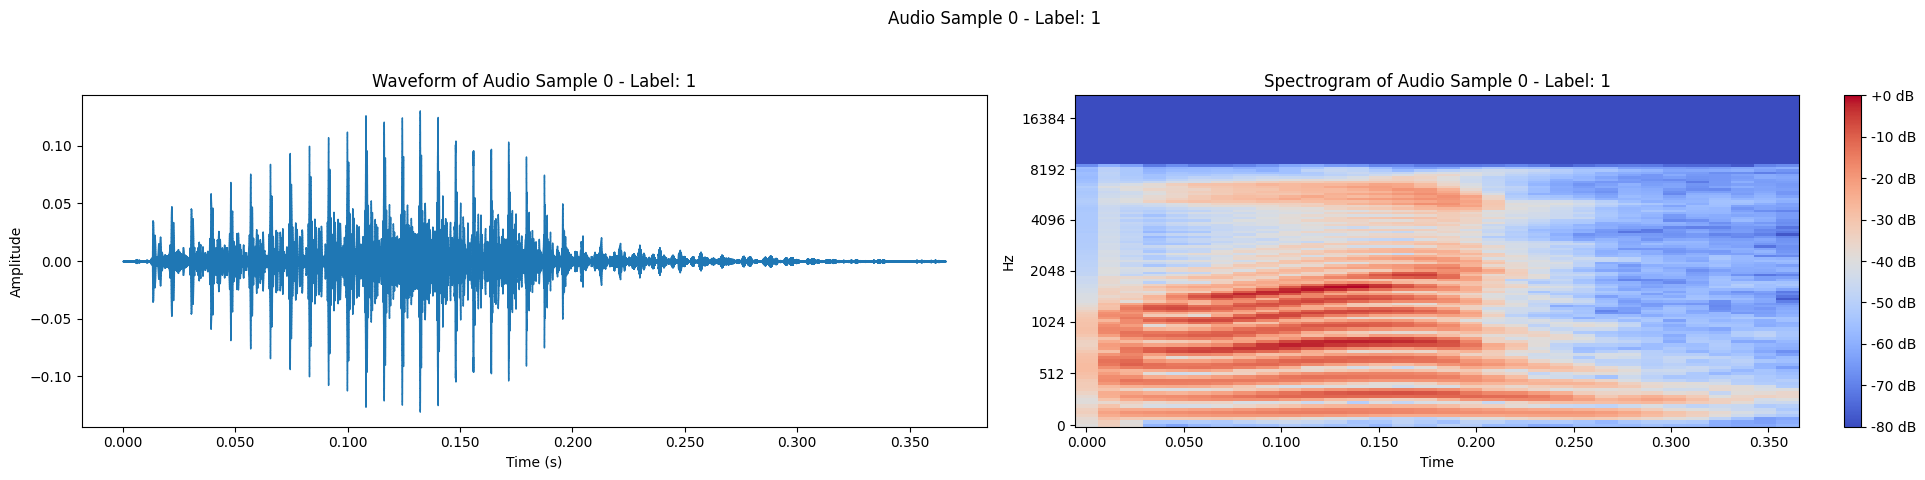

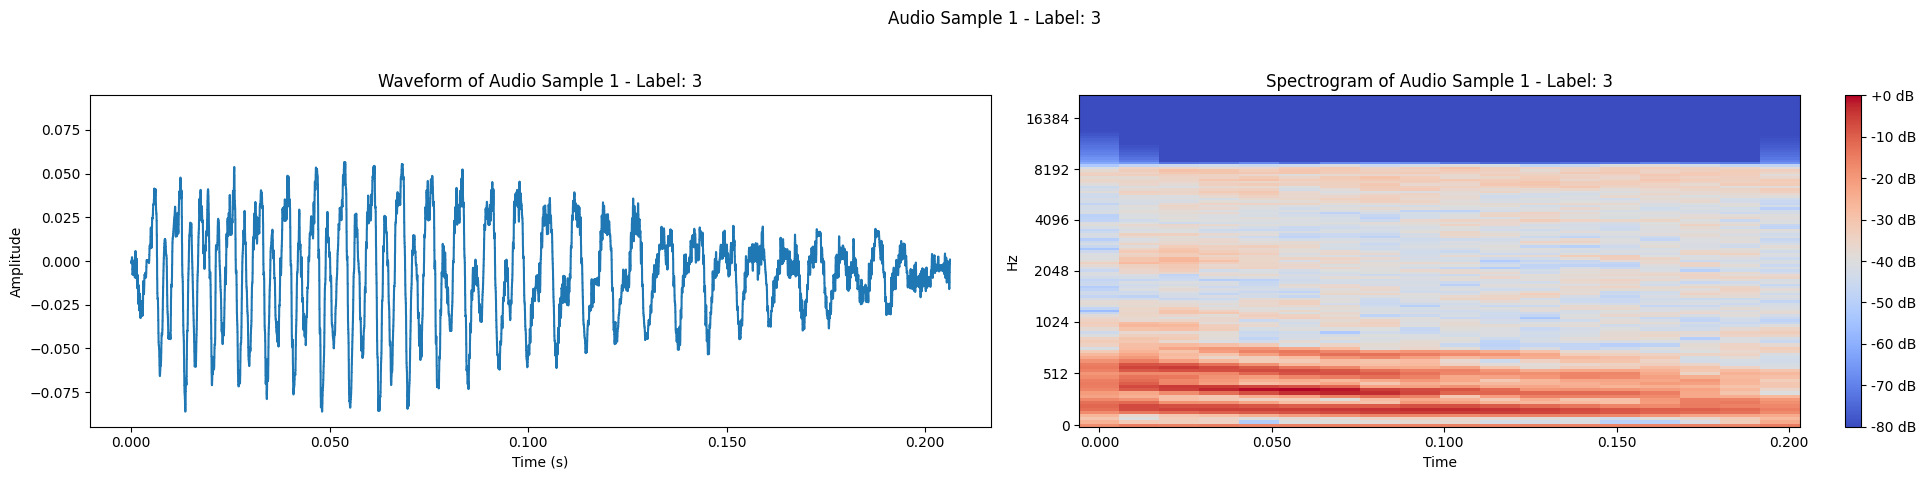

In [3]:
visualize_waveform_and_play_audio(y_audio[:2], wavs[:2])

#### Augmented Audio Samples

This signal seems to have lots of amplitudes, right, and varying length, based on the person, voice, etc. We have prepared an MNIST dataset, of numbers. However, if we change certain things about the signal, would it necessarily change the label. For example:
- speeding up or slowing down the speech still gives the same number 
- shifting the pitch as well
- adding noise, making a worse recording should not change the outcome as well

This is all a form of **data augmentation** - changes to our data that does not impact how our model should treat it, while being more adversarial and challenging for it. Below we have prepared one of the examples previously listed - adding Gaussian noise. 

Below is a cell performing all of these perturbations as a function. We have already pre-loaded it for you on the same dataset.

Take a listen and see if the numbers are still discernable. Also, try to examine how the signal looks visually different. Is there anything different about the wav file and the spectrograms? Take a look and answer the questions below.

In [4]:
def augmentation_function(x, pitch_scale_min=0.9, pitch_scale_max=1.1, slow_down_factor=0.85, sigma=0.001):
    import numpy as np
    x = x * np.random.uniform(pitch_scale_min, pitch_scale_max) 
    x = np.interp(np.arange(0, len(x), slow_down_factor), np.arange(0, len(x)), x)
    x = x + np.random.normal(0, sigma, len(x))  
    return x

X_audio_augmented, y_audio_augmented, wavs_augmented = load_audio_data_noisy('data_util/AudioMNIST/free-spoken-digit-dataset/recordings', augmentation_function, max_samples=max_samples)
X_audio_train_augmented, _, y_audio_train_augmented, _ = train_test_split(X_audio_augmented, y_audio_augmented, test_size=0.2, random_state=42)

100%|██████████| 1000/1000 [00:43<00:00, 23.15it/s]


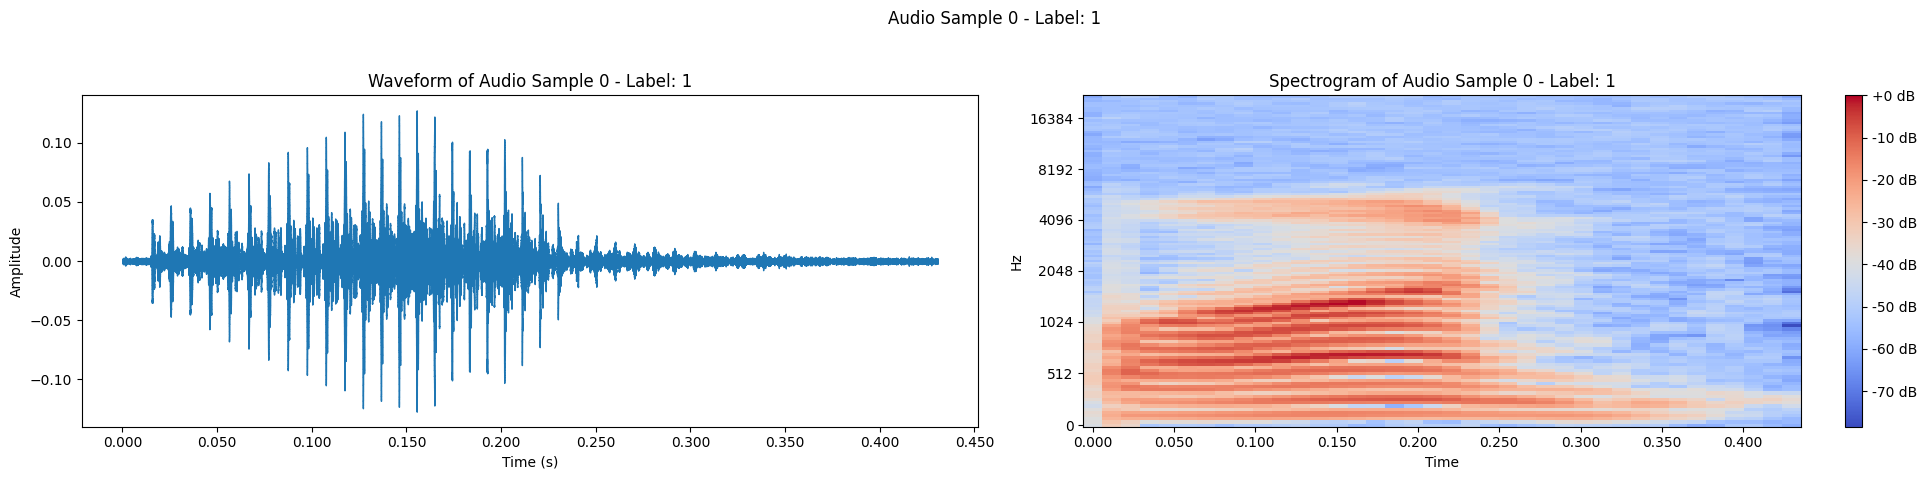

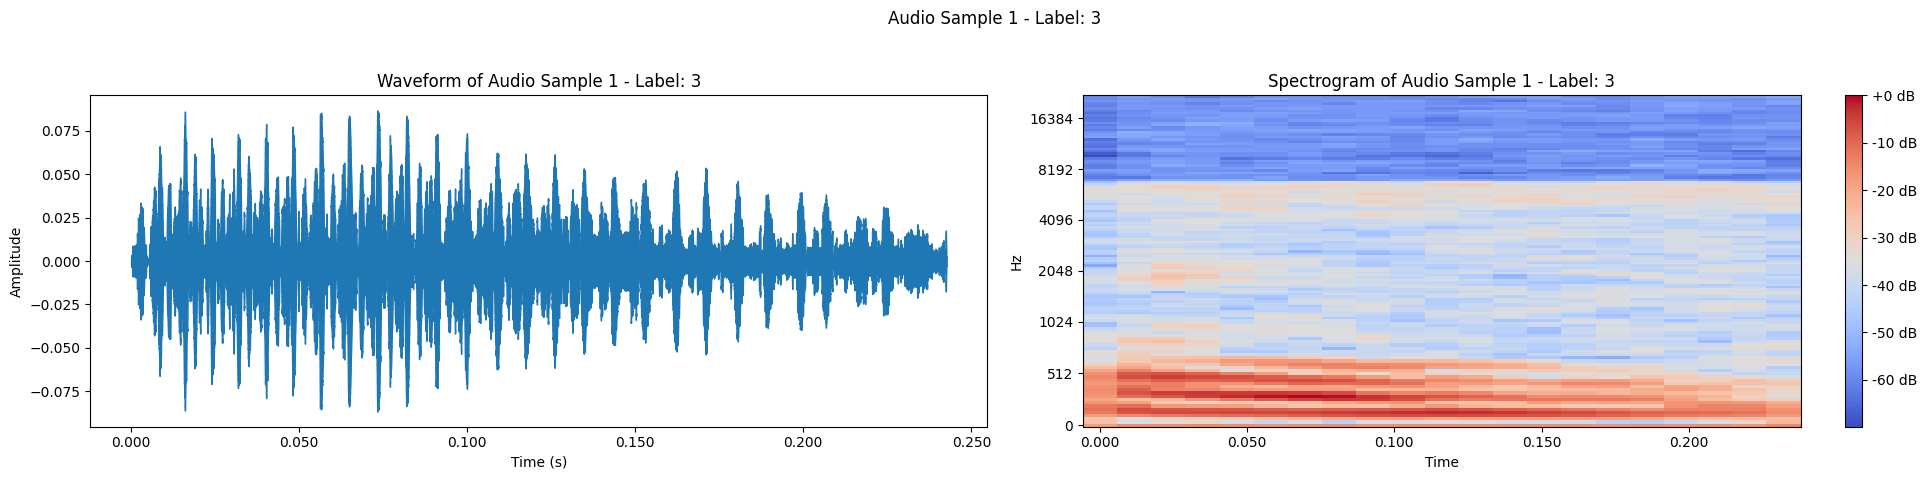

In [5]:
visualize_waveform_and_play_audio(y_audio_augmented[1:4:2], wavs_augmented[1:4:2])

<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 1000px;
">

**Question:**  
How is the amplitude (the left plot) different for the augmented samples – why?  

---

**Answer:**  
<!-- START OF ANSWER -->
Due to the Gaussian noise, the amplitude randomly fluctuates up and down, and it sounds like a distortion. It is visible in the signal being more wavy. 
<!-- END OF ANSWER -->
</div>


<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 1000px;
">

**Question:**  
What would happen if we increase $\sigma$ to 100? What about `slow_down_factor` to 0.001? What if we set min and max pitch the same? Is there anything in common with these proposed augmentations?

---

**Answer:**  
<!-- START OF ANSWER -->
All of these are excessive augmentations that would ruin the generalization of the model.
<!-- END OF ANSWER -->
</div>


<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 1000px;
">

**Question:**  
If you were to make a new data augmentation for audio, what would it be? 

---

**Answer:**  
<!-- START OF ANSWER -->
Speedup, cropping, reverb, echo, etc. are all valid answers. In general, anything that wouldn't flip the label or make the data point unrecognizable is considered a good data augmentation.
<!-- END OF ANSWER -->
</div>




## Images Data Augmentation - MNIST

In this part of the notebook, we will show you a more popular example of data augmentation - namely on images and the MNIST Dataset. It is where data augmentation is more commonly applied in industry and more easily understood. 

![](attachment:image.png)

Please run all code cells below, and you will end up with an interactive menu on the MNIST dataset. There you can play around with different data augmentation and have them visualized in real time. Then, run through the theoretical exercises and try to continue by improving the list of augmentations provided.


In [36]:
def train(model, train_dataloader, val_dataloader, epochs=3):
    model.train()
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []
    for epoch in tqdm(range(epochs)):
        train_loss = []
        for images, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_losses.append(np.mean(train_loss))
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_dataloader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_dataloader))
    return train_losses, val_losses

def test(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [37]:
menu = retrieve_mnist_menu()
menu

## Exercise: Creating Your Own Data Augmentation Pipeline

The time has come. After seeing our examples and playing around with how the given numbers look around, we want you to arrange your own set of augmentations. Your task is to find an augmentation to boost the performance on a training and validation set on a subset of data we offer you. 

You will do all of this in the `transform_aug` variables, which takes in a list of augmentations. This list is currently empty (except for the normalization step, which we leave as an exercise for the reader to know why it is there). Throughout this notebook we have been using the *Albumentations* library to do our data augmentations. This will continue to be the case here. You are free to select from any of the following functions there, and adjust their parameters. Namely:
- `A.Rotate(float rotate, float p)`  
- `A.Affine(float translate_x, float translate_y, float scale, float p)`  
- `A.GaussianBlur(int gaussian_kernel_size, float blur_sigma, float p, bool gaussian_blur)`  
- `A.HorizontalFlip(float p, bool horizontal_flip)`  
- `A.VerticalFlip(float p, bool vertical_flip)`  
- `A.RandomBrightnessContrast(float p, bool random_brightness_contrast)`  
- `A.RGBShift(float p, bool rgb_shift)`  

**Important**: Please take note that sometimes the function can take in both a number, a tuple, and a list!! 

The API of the augmentations is provided on this link https://albumentations.ai/docs/api-reference/. Be careful - the optimal combination may not be all of those augmentations at once, or with all of the parameters! 


In [38]:
## START ANSWER 
p=0.25
## END ANSWER

transform_aug = AlbumentationsTransform(A.Compose([
            # Add your chosen augmentations here, e.g.:
            # A.Rotate(limit=(float rotate), float p), p=0.
            ## START ANSWER 
            A.Rotate(limit=(-1.0*15, 15), p=0.5),
            A.Affine(translate_percent={'x': 0.05, 'y': 0.05}, p=p),
            A.GaussianBlur(blur_limit=3, sigma_limit=2, p=p),
            A.RandomBrightnessContrast(p=p),
            A.RGBShift(p=p),
            ## END ANSWER 
            A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
            
], seed=42))

<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 1000px;
">

**Question:**  
How often would you choose to apply the data augmentation with the parameter **p**? Justify. Think what happens if the values end up between 0 and 1.

---

**Answer:** 
<!-- START OF ANSWER --> 
Except **p=0**, and arguably **p=1** there is no wrong answer. The more often you apply the data augmentation, the more you also lose the representation of your original data. In theory, that might be fine if the data augmentations are minor enough, but if excessive you would likely receive worse performance. If **p=0**, there's just no data augmentation, removing the point completely.
<!-- END OF ANSWER -->

</div>


In [39]:
transform_no_aug = AlbumentationsTransform(A.Compose([
    A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
], seed=42))

## Dataset Parameters and Visualization

Here we set you the subset size you will be working on with your data augmentation from the code cell above. The expectation is that accuracy will increase for the correct set of data augmentation. Play around it - adjust the size of the dataset if you wish to or the samples per class, which attemt to balance out your distribution.

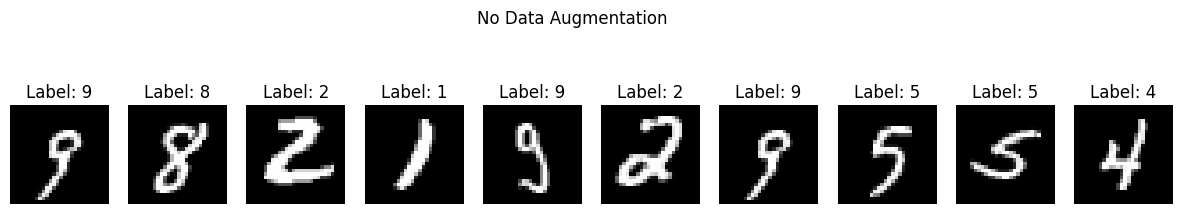

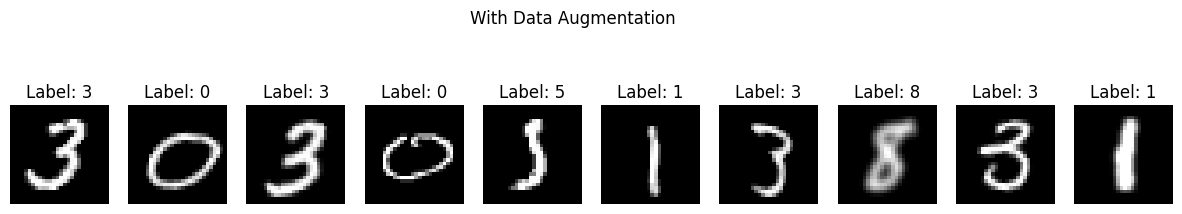

In [40]:
subset_size = 400
num_classes = 10
epochs = 100 #WARNING - IF TOO LOW, MAY NOT WORK
samples_per_class = subset_size // 10

trainset_no_aug, valset_no_aug, _, trainloader_no_aug, valloader_no_aug, testloader = load_mnist_data(train=True,data_augmentations=transform_no_aug,  subset_size=subset_size, )
trainset_aug, valset_aug, _,  trainloader_aug, valloader_aug, _ = load_mnist_data(train=True, data_augmentations=transform_aug, subset_size=subset_size)

visualize_pytorch_dataset_images(trainset_no_aug, "No Data Augmentation")
visualize_pytorch_dataset_images(trainset_aug, "With Data Augmentation")

In [41]:
model_no_aug = SimpleCNN()
losses_no_aug_train, losses_no_aug_val = train(model_no_aug, trainloader_no_aug, valloader_no_aug, epochs=epochs)
acc_no_aug = test(model_no_aug, testloader)

model_aug = SimpleCNN()
losses_aug_train, losses_aug_val = train(model_aug, trainloader_aug, valloader_no_aug, epochs=epochs)
acc_aug = test(model_aug, testloader)

100%|██████████| 100/100 [00:30<00:00,  3.28it/s]


<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 1000px;
">

## Challenge: Accuracy > 88%

We have provided you a data augmentation setup. You have the full capability to improve performance on the MNIST task. We challenge you to reach an accuracy of above 88% **WITHOUT** changing the subset size. You can add whatever data augmentations you want, change the probabilities of the augmentation **p**, or increase training time. To get test sense performance, run the cell below.



</div>


<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 1000px;
">

**Question:**  
What data augmentations did you choose and why? Are there any data augmentations you did NOT choose? If so, why? Feel free to come back to this questions after experiemnting.

---

**Answer:**  
<!-- START OF ANSWER -->
We expect the students to use a combination of blurs, (moderate) rotations and affine transofmrations or anything to change the color distribution of the image. Performance should decrease in case of data augmentations that "flip" the label in some way (zooming in too much to an 8, roating a 6). Things like that confuse the models instead of making them more robust against noise.
<!-- END OF ANSWER -->

</div>


Accuracy without augmentation: 0.8258
Accuracy with augmentation: 0.8922


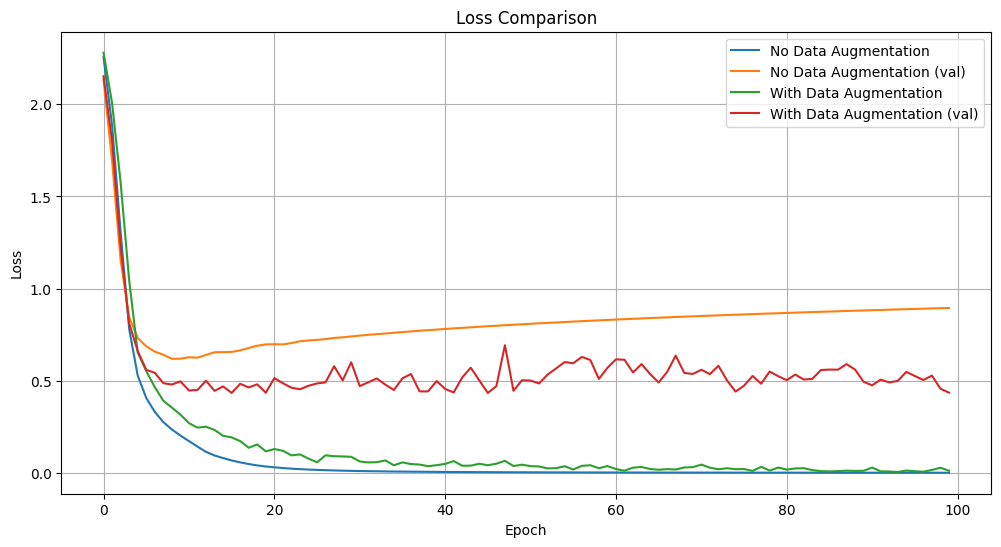

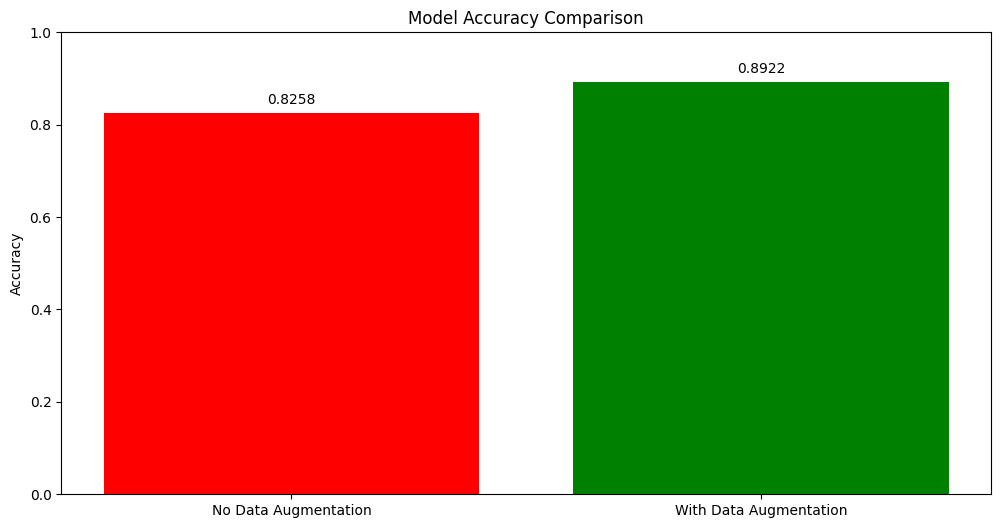

In [42]:
from visualization.show_metrics import compare_two_losses
import matplotlib.pyplot as plt

print(f"Accuracy without augmentation: {acc_no_aug:.4f}")
print(f"Accuracy with augmentation: {acc_aug:.4f}")

def compare_two_losses(loss_a, loss_a_val, loss_a_label, loss_b, loss_b_val, loss_b_label):


    plt.figure(figsize=(12, 6))
    plt.plot(loss_a, label=loss_a_label)
    plt.plot(loss_a_val, label=loss_a_label + ' (val)')
    plt.plot(loss_b, label=loss_b_label)
    plt.plot(loss_b_val, label=loss_b_label + ' (val)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.title('Loss Comparison')
    plt.show()
    

def plot_accuracy_comparison(acc_no_aug_list, acc_aug_list):
    accuracies = [acc_no_aug_list[-1], acc_aug_list[-1]]
    labels = ['No Data Augmentation', 'With Data Augmentation']

    plt.figure(figsize=(12, 6))
    plt.bar(labels, accuracies, color=['red', 'green'])
    plt.ylim([0, 1])
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')

    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center')

    plt.show()

    
compare_two_losses(losses_no_aug_train, losses_no_aug_val, 'No Data Augmentation', losses_aug_train, losses_aug_val, "With Data Augmentation")
plot_accuracy_comparison([acc_no_aug], [acc_aug])

<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 1000px;
">

**Question:**  
Examine the training loss over different epochs (both validation and training) on the augmented and non-augmented data. What difference do you see? Why do you see it? What about the validation loss?

---

**Answer:**  
The augmented training loss is much less stable than the non-augmented one. This makes sense as augmentations change over forward passes and the task is overall much harder. The validation loss on the non-augmented set starts rising. This indicates overfitting.
</div>




In [ ]:
subset_sizes = [80, 160, 320, 640, 1280]  # Different subset sizes to try
num_classes = 10
epochs = 100 #WARNING - IF TOO LOW, MAY NOT WORK
samples_per_class = subset_size // 10

acc_no_aug_list = []
acc_aug_list = []

for subset_size in subset_sizes:
    num_classes = 10
    samples_per_class = subset_size // 10
    
    num_classes = 10
    samples_per_class = subset_size // 10

    trainset_no_aug, valset_no_aug, _, trainloader_no_aug, valloader_no_aug, testloader = load_mnist_data(train=True,data_augmentations=transform_no_aug,  subset_size=subset_size, )
    trainset_aug, valset_aug, _,  trainloader_aug, valloader_aug, _ = load_mnist_data(train=True, data_augmentations=transform_aug, subset_size=subset_size)
    
    model_no_aug_curr = SimpleCNN()
    losses_no_aug_train, losses_no_aug_val = train(model_no_aug_curr, trainloader_no_aug, valloader_no_aug, epochs=epochs)
    acc_no_aug_curr = test(model_no_aug_curr, testloader)

    model_aug_curr = SimpleCNN()
    losses_aug_train, losses_aug_val = train(model_aug_curr, trainloader_aug, valloader_no_aug, epochs=epochs)
    acc_aug_curr = test(model_aug_curr, testloader)

    acc_no_aug_list.append(acc_no_aug_curr)
    acc_aug_list.append(acc_aug_curr)

plot_accuracy_vs_subset_size(
    subset_sizes=subset_sizes,
    acc_no_aug=acc_no_aug_list,
    acc_with_aug=acc_aug_list,
    title='Performance: Impact of Data Augmentation vs. Subset Size'
)

100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 650px;
">

**Question:**  
Reason about the performance on the augmented data over the different subset sizes on the plot. When is no augmentation better?

---

**Answer:**  
There are points when the amount of data shown is sufficient for the task at hand. Then the data augmentation is most likely distancing the model more from reality than is fully necessary. The best thing to do for your model, of course is to add more data - data augmentation is a remedy, but not a replacement.
</div>




### Contrail Application

Now comes the time to apply our data augmentations to real data, not just a toy problem like MNIST. 

We are in luck, however! We can (mostly) just reapply all of the data augmentations we have done to MNIST. The following section details how data augmentation is applied and lets you play with another set of augmentations to improve contrail performance. 

Alternatively, you could also take a look at our set of data augmentatiosn they are not necessarily the best set of augmentations for all cases. Please answer all of the theoretical questions, and run through the code. Our configuration of data augmentations is not necessarily optimal.

In [ ]:
from visualization.interactive_menu import retrieve_contrails_menu
menu = retrieve_contrails_menu()
menu

<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 650px;
">

**Question:**  
Is the data augmentations on the contrails different algorithmically? What has changed?

---

**Answer:**  
The labels now require augmentation as well.
</div>




<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 650px;
">

**Question:**  
Notice that padding is now an option. What padding would you choose? Reflect? Replicate? Could the padding be harmful?

---

**Answer:**  
Reflect seems like the best padding for the image. You by reflecting, you may bias the image towards learning the points of reflection and how the contrails have the certain angles to them. A less bias-inducing padding would be relflect and flipped so that the trajectory is maintained.
</div>




### Intermezzo: Transfer Learning (Not Part of Session Material)

Transfer learning is a machine learning technique where knowledge learned from a previous task is applied to a new one. Intuitively, if these tasks are related, parts can be re-used between them. In the context of machine and deep learning (specifically with neural networks), this very often means using or starting off with previously learned weights on a similar task. An example task could be a classifier on cars that you now wanna apply on trucks.

This is also what happens in the paper we discuss in these exercises. It uses what they call "few-shot learning" for contrail detection where the initial weights of the model used here are from segmentation on ImageNet, one of the largest image datasets and most famous benchmarks in all of deep learning. It is a "starting point" to whatever we end up doing, as long as the tasks are related.

We mention it here as **it is related to transfer learning** - it once again is used in cases with little data and helps reduce generalization error by including example from multiple datasets. 

Some resources for the curious ones are listed below:
- https://www.ibm.com/think/topics/transfer-learning
- https://medium.com/@davidfagb/guide-to-transfer-learning-in-deep-learning-1f685db1fc94
- https://arxiv.org/abs/2104.02144



In [ ]:
p=0.5

transform_contrails_aug = A.Compose([
            A.Resize(128, 128),
            A.Rotate(limit=(-1.0*15, 15), border_mode=cv2.BORDER_REFLECT_101, p=0.5),
            A.Affine(translate_percent={'x': 0.1, 'y': 0.1}, border_mode=cv2.BORDER_REFLECT_101, p=p),
            A.GaussianBlur(blur_limit=3, sigma_limit=2, p=p),
            A.RandomBrightnessContrast(p=p),
            A.Perspective(scale=(0.05, 0.1), border_mode=cv2.BORDER_REFLECT_101, p=p),
            A.RGBShift(p=p),
            A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
        ])

transform_no_aug_contrails = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
])


EPOCHS = 100

In [ ]:
train_contrail_network(transform_no_aug_contrails, EPOCHS, "dice", "base", dataset="own", experiment_name="no_augmentation-dice")

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
train_contrail_network(transform_contrails_aug, EPOCHS, "dice", "base", dataset="own", experiment_name="augmentation-dice")


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

#### Are these predictions even good? 

Right now we have two trained contrail models - however, we have not defined ways to evaluate them. The reason is that getting a notion of how good the contrails model (or any deep learning model in industry for that matter) is hard. Here we show a naive approach of defining our metrics as "the number of matching pixels".

<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 650px;
">

**Exercise:**  
Run the code cells below. What do you see about these predictions? Are these notions of accuracy reasonable?

---

**Answer:**  
The students should see that pure white and pure black alues till get some notions of accuracy, despite being totally useless. This is a bridge to the metrics exercises.
</div>




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def evaluate_binary_image(input_img, label_img, threshold=0.5):
    # --- Load input image ---
    if isinstance(input_img, str):
        input_img = np.array(Image.open(input_img).convert('L')) / 255.0
    elif isinstance(input_img, np.ndarray) and input_img.ndim == 3:
        input_img = np.mean(input_img, axis=2)

    # --- Load label image (RGBA) ---
    if isinstance(label_img, str):
        label_img_pil = Image.open(label_img).convert('RGBA')
        label_arr = np.array(label_img_pil)
    elif isinstance(label_img, np.ndarray):
        label_arr = label_img

    # Alpha mask: 1 for visible pixels, 0 for transparent
    alpha_mask = label_arr[..., 3] > 0

    # Black pixels as label = 1
    black_mask = (label_arr[..., :3].sum(axis=2) == 0)
    label_bin = np.zeros(black_mask.shape, dtype=np.float32)
    label_bin[black_mask & alpha_mask] = 1.0  # only visible black pixels

    pred_bin = (input_img > threshold).astype(np.float32)

    accuracy = np.mean(pred_bin == label_bin)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(input_img, cmap='gray')
    plt.title("Input / Prediction")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(label_bin, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    overlay = np.zeros((*pred_bin.shape, 3))
    overlay[..., 0] = label_bin  # red = GT
    overlay[..., 1] = pred_bin   # green = prediction
    overlay[..., 2] = label_bin * pred_bin  # blue = overlap
    plt.imshow(overlay, cmap='gray')
    plt.title(f"Overlay (GT=R, Pred=G)\nAccuracy={accuracy:.3f}")
    plt.axis('off')

    plt.show()



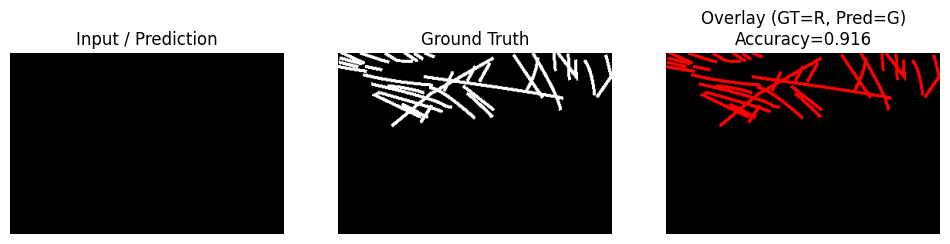

In [ ]:
evaluate_binary_image(np.zeros((235, 355)), "contrail-seg/data/goes/florida/mask/florida_2020_03_05_0101.png")

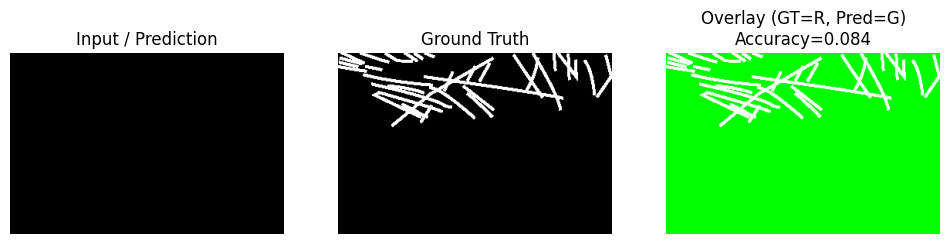

In [ ]:
evaluate_binary_image(np.ones((235, 355)), "contrail-seg/data/goes/florida/mask/florida_2020_03_05_0101.png")

In the following section, you will learn about how you can better evaluate your model.

# Metrics

---

--- 

# Ethics: Responsibilities and Policy

Once done, this will include the ethics exercises defined. 